## BERT Classifier Sentiment Detection

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
import torch
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Sentiments Dataset and Preprocessing

https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv 

https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv

In [10]:
# Define mapping
simplified_sentiment_mapping = {
        'happy': ['joy', 'admiration', 'amusement', 'excitement', 'approval', 'gratitude', 'optimism', 'pride', 'love'],
        'distressed': ['sadness', 'grief', 'disappointment', 'remorse', 'nervousness', 'fear', 'anger', 'disgust', 'annoyance', 'disapproval', 'embarrassment', 'desire'],
        'neutral': ['neutral', 'curiosity', 'confusion', 'realization', 'surprise', 'caring']
    }
# Load GoEmotions clearly
goemotions_df_1 = pd.read_csv('goemotions_1.csv')
goemotions_df_2 = pd.read_csv('goemotions_2.csv')
# Simplified function to map original labels clearly into 4 sentiment classes
def map_to_simple_sentiment(row):
    emotion_columns =  {
        'happy': ['joy', 'admiration', 'amusement', 'excitement', 'approval', 'gratitude', 'optimism', 'pride', 'love'],
        'distressed': ['sadness', 'grief', 'disappointment', 'remorse', 'nervousness', 'fear', 'anger', 'disgust', 'annoyance', 'disapproval', 'embarrassment', 'desire'],
        'neutral': ['neutral', 'curiosity', 'confusion', 'realization', 'surprise', 'caring']
    }
    
    for simple_sentiment, labels in emotion_columns.items():
        if row[labels].sum() > 0:
            return simple_sentiment
    return 'neutral'  # Default if no clear labels found

# Apply sentiment mapping
goemotions_df_1['sentiment_label'] = goemotions_df_1.apply(map_to_simple_sentiment, axis=1)
goemotions_df_2['sentiment_label'] = goemotions_df_2.apply(map_to_simple_sentiment, axis=1)


In [11]:
# Merge the two GoEmotions DataFrames clearly
merged_goemotions_df = pd.concat([goemotions_df_1, goemotions_df_2], ignore_index=True)

# Keep only required columns explicitly ("text" and "sentiment_label")
final_goemotions_df = merged_goemotions_df[['text', 'sentiment_label']]

# Save to CSV clearly for ease of use later
final_goemotions_df.to_csv('sentiments.csv', index=False)

# Verify by displaying the head of the final DataFrame
print(final_goemotions_df.head())


                                                text sentiment_label
0                                    That game hurt.      distressed
1   >sexuality shouldn’t be a grouping category I...         neutral
2     You do right, if you don't care then fuck 'em!         neutral
3                                 Man I love reddit.           happy
4  [NAME] was nowhere near them, he was by the Fa...         neutral


neutral       55571
happy         49843
distressed    34586
Name: sentiment_label, dtype: int64


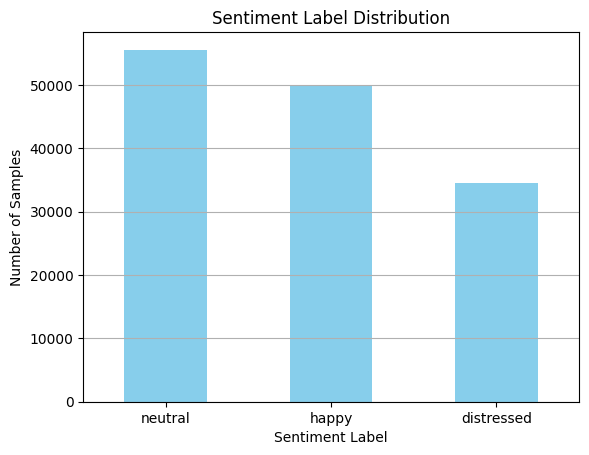

In [12]:
# Check clearly how many data points you have for each sentiment label
sentiment_distribution = final_goemotions_df['sentiment_label'].value_counts()

# Display sentiment distribution
print(sentiment_distribution)

# Visualize sentiment distribution explicitly with a bar plot

sentiment_distribution.plot(kind='bar', color='skyblue')
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


## Handling Imbalance

In [13]:


# Load your combined dataset
df = pd.read_csv('sentiments.csv')

# Check the distribution explicitly
print(df['sentiment_label'].value_counts())

# Define target sample size (e.g., equal to smallest class or a reasonable number)
target_size = df['sentiment_label'].value_counts().min()

# Perform downsampling clearly
balanced_df = pd.concat([
    df[df['sentiment_label'] == label].sample(target_size, random_state=42)
    for label in df['sentiment_label'].unique()
])

# Verify balanced distribution
print(balanced_df['sentiment_label'].value_counts())

# Save the balanced dataset
balanced_df.to_csv('balanced_sentiments.csv', index=False)


neutral       55571
happy         49843
distressed    34586
Name: sentiment_label, dtype: int64
distressed    34586
neutral       34586
happy         34586
Name: sentiment_label, dtype: int64


### Split Dataset Train,Val,Test for Sentiments

In [27]:
# Load sentiment dataset explicitly
sentiment_df = pd.read_csv('balanced_sentiments.csv')
sentiment_mapping = {'happy': 0, 'distressed': 1, 'neutral': 2}
sentiment_df['sentiment_label'] = sentiment_df['sentiment_label'].map(sentiment_mapping)
# Split sentiment data explicitly into Train-Validation-Test (80-10-10 split recommended)

sent_train_val, sent_test = train_test_split(sentiment_df, test_size=0.1, stratify=sentiment_df['sentiment_label'], random_state=42)
sent_train, sent_val = train_test_split(sent_train_val, test_size=0.11, stratify=sent_train_val['sentiment_label'], random_state=42)


### Distribution Similarity of Output labels

In [28]:
# Explicitly verify sentiment distribution similarly
print("Training sentiment distribution:")
print(sent_train['sentiment_label'].value_counts(normalize=True))

print("\nValidation sentiment distribution:")
print(sent_val['sentiment_label'].value_counts(normalize=True))

print("\nTest sentiment distribution:")
print(sent_test['sentiment_label'].value_counts(normalize=True))

Training sentiment distribution:
2    0.333333
0    0.333333
1    0.333333
Name: sentiment_label, dtype: float64

Validation sentiment distribution:
0    0.333398
1    0.333301
2    0.333301
Name: sentiment_label, dtype: float64

Test sentiment distribution:
1    0.333365
2    0.333365
0    0.333269
Name: sentiment_label, dtype: float64


## Fine tuning BERT for Sentiments

#### Tokenization

In [33]:


# Tokenization
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_data(texts, labels):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128), labels

In [34]:
# Dataset class explicitly defined
class MentalHealthDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

#### Training the model

In [39]:

train_encodings, train_labels = tokenize_data(sent_train['text'].tolist(), sent_train['sentiment_label'].tolist())
val_encodings, val_labels = tokenize_data(sent_val['text'].tolist(), sent_val['sentiment_label'].tolist())

train_dataset = MentalHealthDataset(train_encodings, train_labels)
val_dataset = MentalHealthDataset(val_encodings, val_labels)

# BERT fine-tuning explicitly
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Adjust num_labels clearly

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5196 [00:00<?, ?it/s]

{'loss': 0.8464, 'grad_norm': 4.180497646331787, 'learning_rate': 1.8075442648190917e-05, 'epoch': 0.19}
{'loss': 0.7768, 'grad_norm': 3.5033185482025146, 'learning_rate': 1.6150885296381833e-05, 'epoch': 0.38}
{'loss': 0.7638, 'grad_norm': 3.6267378330230713, 'learning_rate': 1.4226327944572749e-05, 'epoch': 0.58}
{'loss': 0.7512, 'grad_norm': 2.606947660446167, 'learning_rate': 1.2301770592763664e-05, 'epoch': 0.77}
{'loss': 0.7527, 'grad_norm': 4.552700519561768, 'learning_rate': 1.0377213240954582e-05, 'epoch': 0.96}


  0%|          | 0/322 [00:00<?, ?it/s]

{'eval_loss': 0.7446379661560059, 'eval_runtime': 75.5298, 'eval_samples_per_second': 136.012, 'eval_steps_per_second': 4.263, 'epoch': 1.0}
{'loss': 0.6991, 'grad_norm': 4.3276190757751465, 'learning_rate': 8.452655889145497e-06, 'epoch': 1.15}
{'loss': 0.6854, 'grad_norm': 4.737748146057129, 'learning_rate': 6.528098537336414e-06, 'epoch': 1.35}
{'loss': 0.69, 'grad_norm': 4.546692848205566, 'learning_rate': 4.6035411855273295e-06, 'epoch': 1.54}
{'loss': 0.6876, 'grad_norm': 5.616837978363037, 'learning_rate': 2.678983833718245e-06, 'epoch': 1.73}
{'loss': 0.6802, 'grad_norm': 4.383632659912109, 'learning_rate': 7.54426481909161e-07, 'epoch': 1.92}


  0%|          | 0/322 [00:00<?, ?it/s]

{'eval_loss': 0.7556121945381165, 'eval_runtime': 72.0925, 'eval_samples_per_second': 142.497, 'eval_steps_per_second': 4.466, 'epoch': 2.0}
{'train_runtime': 5858.2414, 'train_samples_per_second': 28.373, 'train_steps_per_second': 0.887, 'train_loss': 0.7310747289033557, 'epoch': 2.0}


TrainOutput(global_step=5196, training_loss=0.7310747289033557, metrics={'train_runtime': 5858.2414, 'train_samples_per_second': 28.373, 'train_steps_per_second': 0.887, 'total_flos': 1.0933546516978176e+16, 'train_loss': 0.7310747289033557, 'epoch': 2.0})

#### Accuracy For Validation Dataset

In [43]:
predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(axis=1)

accuracy = accuracy_score(val_labels, pred_labels)
print(f"Validation accuracy explicitly: {accuracy:.2%}")


  0%|          | 0/322 [00:00<?, ?it/s]

Validation accuracy explicitly: 67.22%


#### Added more epoch to increase the accuracy

In [46]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,  # explicitly clearly total epochs explicitly desired
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)
trainer.train(resume_from_checkpoint='./results/checkpoint-5196')


/Users/m276901/Library/Python/3.9/lib/python/site-packages/transformers/trainer.py:3262: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OP

  0%|          | 0/12990 [00:00<?, ?it/s]

/Users/m276901/Library/Python/3.9/lib/python/site-packages/transformers/trainer.py:2944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = torch.load(rng_

{'loss': 0.6564, 'grad_norm': 3.399953842163086, 'learning_rate': 1.1531947652040033e-05, 'epoch': 2.12}
{'loss': 0.6592, 'grad_norm': 4.795050621032715, 'learning_rate': 1.0762124711316398e-05, 'epoch': 2.31}
{'loss': 0.668, 'grad_norm': 5.626112937927246, 'learning_rate': 9.992301770592764e-06, 'epoch': 2.5}
{'loss': 0.672, 'grad_norm': 4.129746913909912, 'learning_rate': 9.22247882986913e-06, 'epoch': 2.69}
{'loss': 0.6669, 'grad_norm': 2.874091148376465, 'learning_rate': 8.452655889145497e-06, 'epoch': 2.89}


  0%|          | 0/322 [00:00<?, ?it/s]

{'eval_loss': 0.759364902973175, 'eval_runtime': 71.3846, 'eval_samples_per_second': 143.911, 'eval_steps_per_second': 4.511, 'epoch': 3.0}
{'loss': 0.6455, 'grad_norm': 5.7913689613342285, 'learning_rate': 7.682832948421864e-06, 'epoch': 3.08}
{'loss': 0.6038, 'grad_norm': 6.834770202636719, 'learning_rate': 6.91301000769823e-06, 'epoch': 3.27}
{'loss': 0.6022, 'grad_norm': 4.921018123626709, 'learning_rate': 6.143187066974596e-06, 'epoch': 3.46}
{'loss': 0.6073, 'grad_norm': 5.903962135314941, 'learning_rate': 5.373364126250963e-06, 'epoch': 3.66}
{'loss': 0.6036, 'grad_norm': 6.465673923492432, 'learning_rate': 4.6035411855273295e-06, 'epoch': 3.85}


  0%|          | 0/322 [00:00<?, ?it/s]

{'eval_loss': 0.8106116056442261, 'eval_runtime': 71.4212, 'eval_samples_per_second': 143.837, 'eval_steps_per_second': 4.508, 'epoch': 4.0}
{'loss': 0.6004, 'grad_norm': 4.466899871826172, 'learning_rate': 3.833718244803695e-06, 'epoch': 4.04}
{'loss': 0.553, 'grad_norm': 6.708946228027344, 'learning_rate': 3.063895304080062e-06, 'epoch': 4.23}
{'loss': 0.5509, 'grad_norm': 8.282623291015625, 'learning_rate': 2.294072363356428e-06, 'epoch': 4.43}
{'loss': 0.5466, 'grad_norm': 5.171898365020752, 'learning_rate': 1.5242494226327945e-06, 'epoch': 4.62}
{'loss': 0.5585, 'grad_norm': 5.789856910705566, 'learning_rate': 7.54426481909161e-07, 'epoch': 4.81}


  0%|          | 0/322 [00:00<?, ?it/s]

{'eval_loss': 0.8679877519607544, 'eval_runtime': 71.5476, 'eval_samples_per_second': 143.583, 'eval_steps_per_second': 4.501, 'epoch': 5.0}
{'train_runtime': 6212.5397, 'train_samples_per_second': 66.888, 'train_steps_per_second': 2.091, 'train_loss': 0.3650315952080777, 'epoch': 5.0}


TrainOutput(global_step=12990, training_loss=0.3650315952080777, metrics={'train_runtime': 6212.5397, 'train_samples_per_second': 66.888, 'train_steps_per_second': 2.091, 'total_flos': 2.733386629244544e+16, 'train_loss': 0.3650315952080777, 'epoch': 5.0})

#### Validation accuracy After added epochs

In [47]:
# Explicit accuracy explicitly clearly:
predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(axis=1)

accuracy = accuracy_score(val_labels, pred_labels)
print(f"Validation Accuracy explicitly: {accuracy:.2f}")
print(classification_report(val_labels, pred_labels))

  0%|          | 0/322 [00:00<?, ?it/s]

Validation Accuracy explicitly: 0.65
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      3425
           1       0.64      0.71      0.68      3424
           2       0.62      0.50      0.55      3424

    accuracy                           0.65     10273
   macro avg       0.65      0.65      0.65     10273
weighted avg       0.65      0.65      0.65     10273



#### Accuracy for Test Dataset

In [49]:
test_encodings, test_labels = tokenize_data(sent_test['text'].tolist(), sent_test['sentiment_label'].tolist())
test_dataset = MentalHealthDataset(test_encodings, test_labels)
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)

accuracy = accuracy_score(test_labels, pred_labels)
print(f"Test Accuracy explicitly: {accuracy:.2f}")
print(classification_report(test_labels, pred_labels))

  0%|          | 0/325 [00:00<?, ?it/s]

Test Accuracy explicitly: 0.66
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      3458
           1       0.65      0.73      0.68      3459
           2       0.63      0.52      0.57      3459

    accuracy                           0.66     10376
   macro avg       0.66      0.66      0.66     10376
weighted avg       0.66      0.66      0.66     10376



#### Confusion matrix for Test data

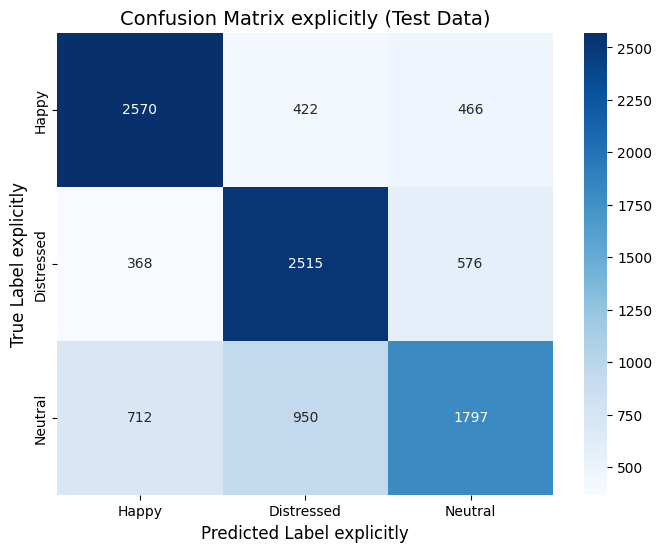

In [51]:
class_labels = ['Happy', 'Distressed', 'Neutral']

cm = confusion_matrix(test_labels, pred_labels)

#  visualize confusion matrix clearly
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

#  label axes clearly
plt.xlabel('Predicted Label explicitly', fontsize=12)
plt.ylabel('True Label explicitly', fontsize=12)
plt.title('Confusion Matrix explicitly (Test Data)', fontsize=14)
plt.show()

#### Model Saved

In [52]:
model.save_pretrained("./bert_sentiment_classifier")
tokenizer.save_pretrained("./bert_sentiment_classifier")


('./bert_sentiment_classifier/tokenizer_config.json',
 './bert_sentiment_classifier/special_tokens_map.json',
 './bert_sentiment_classifier/vocab.txt',
 './bert_sentiment_classifier/added_tokens.json',
 './bert_sentiment_classifier/tokenizer.json')

#### Testing the model with random texts

In [5]:
from transformers import BertForSequenceClassification, BertTokenizerFast

# explicitly load the fine-tuned model explicitly
model = BertForSequenceClassification.from_pretrained('./bert_sentiment_classifier')
tokenizer = BertTokenizerFast.from_pretrained('./bert_sentiment_classifier')

model.eval()

# explicitly your input clearly
text = "I'm feeling anxious  and stressed"

# explicitly tokenize input clearly
encoding = tokenizer(text, return_tensors='pt')

# explicitly get model outputs (logits) clearly
with torch.no_grad():  # explicitly disable gradient computation for inference clearly
    output = model(**encoding)

# explicitly predict clearly (get class with highest logit clearly)
predicted_class_id = torch.argmax(output.logits, dim=-1).item()

# explicitly map back clearly to your labels explicitly
id_to_label = {0: 'Happy', 1: 'Distressed', 2: 'Neutral'}

predicted_label = id_to_label[predicted_class_id]

# explicitly print prediction clearly
print(f"Predicted Sentiment explicitly: {predicted_label} (Class ID: {predicted_class_id})")


Predicted Sentiment explicitly: Distressed (Class ID: 1)
